# Gradient vector flow

Gradient vector flow are used to smooth and diffuse the field of image gradient.

From the gradients of the image $f=G_\sigma I$, the gradient vector flow $v$ :

$ \mu \nabla^2 v + (\lambda + \mu) \nabla (\nabla \cdot v) + q (\nabla f - v) = 0$

It has been introduced as an external force for active contours base segmentation.

Gradient vector flow has been used to segment touching nuclei [3] by backtracking the estimating the flow.

1) https://en.wikipedia.org/wiki/Gradient_vector_flow
2) https://ieeexplore.ieee.org/document/609299
3) https://pubmed.ncbi.nlm.nih.gov/18638189/



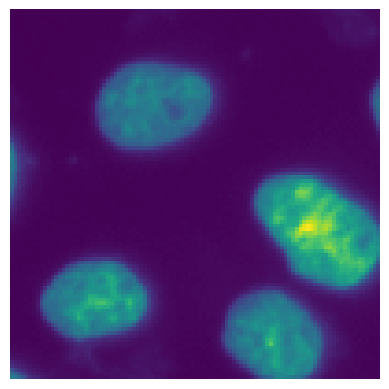

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
image = io.imread('../data/nuclei.tif')[:100,:100]
plt.imshow(image)
plt.axis('off');

We define functions for visualizing flows

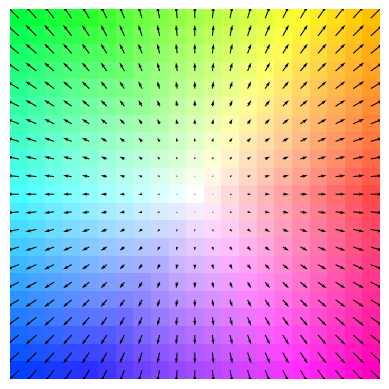

In [72]:
from skimage.color import hsv2rgb
from math import pi

def flow2rgb(flow):    
    '''Convert 2D vector flow into a HSV code'''
    s = np.sqrt(np.sum(np.square(flow), axis=0))
    s = s / s.max()    
    h = ( 2*pi - np.arctan2(flow[0], flow[1])) / (2*pi)
    v = 255 * np.ones_like(s)    
    return hsv2rgb(np.stack([h,s,v],axis=2)).astype(np.uint8)

def show_flow(v, stride=5, color='k'):
    '''Display the flow as HSV and quiver'''
    plt.imshow(flow2rgb(v))
    x,y = np.meshgrid(np.arange(v.shape[2]), np.arange(v.shape[1]))
    plt.quiver(x[::stride,::stride],y[::stride,::stride],v[1,::stride,::stride],-v[0,::stride,::stride],color=color)
    plt.axis('off')

show_flow(np.roll(np.stack(np.meshgrid(np.r_[-10:11],np.r_[-10:11])),shift=1,axis=0),1)


We compute now the gradient vector flow on the image

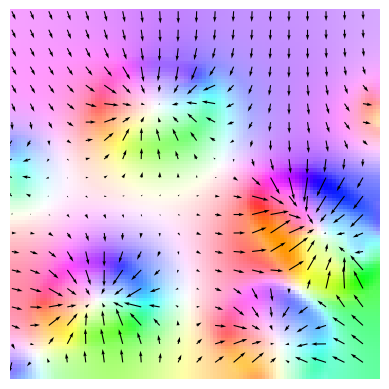

In [261]:
from scipy import ndimage

def gradient_vector_flow(image, alpha=1, mu=1, prefilter=1, num_iter=1000):
    '''Compute the gradient vector flow using an iterative scheme for solving the PDE'''
    f = np.stack(np.gradient(ndimage.gaussian_filter(image.astype(float), prefilter)))
    q = np.sum(np.square(f), axis=0)    
    q[q < q.mean()] = 0
    q[q > 0] = 1
    v = f
    for _ in range(num_iter):
        dv = sum([
            alpha * np.stack([ndimage.laplace(x) for x in v]),
            (alpha+mu) * np.stack(np.gradient(sum([ np.gradient(v[k],axis=k) for k in range(image.ndim) ]))),
            q * (f - v)])
        v = v + dv / np.abs(dv).max()        
        if np.abs(dv).max() < 1e-6:
            break
        
    return v

flow = gradient_vector_flow(image, 1, 2, 2)
show_flow(flow)


Trace back the flow starting from each pixel in the image

In [262]:
from numba import jit

@jit(nopython=True)
def integrate_flow(flow, start, endpoints):    
    '''Integrate the flow from a starting position

    Parameters
    ----------
    flow : array (2,H,W) or (3,P,H,W)
        flow
    start : array (2,) or (3,)
        starting point
    endpoints : array (2,H,W) or (3,P,H,W)
        pre computed enpoints
    
    Returns
    -------
    A list of position
    '''
    p = start
    dp = dq = np.zeros(p.shape, dtype=flow.dtype)    
    streamline = [p]
    for _ in range(400):        
        # get the flow direction        
        dp = flow[:,p[0],p[1]] if flow.ndim == 3 else flow[:,p[0],p[1],p[2]] 
        # update
        p = p + np.array([round(x) for x in dp], dtype=np.int64)
        p = np.maximum(0,np.minimum(np.array(flow.shape[1:])-1, p))
        streamline.append(p)
        # stop if flow turns more than 90 deg        
        if np.arccos(np.dot(dq.ravel(),dp.ravel())) > pi / 2:
            break        
        # stop if encounter an precomputed endpoint
        e = endpoints[:,p[0],p[1]] if flow.ndim == 3 else endpoints[:,p[0],p[1],p[2]] 
        if np.all(e != 0):
            streamline.append(e.astype(np.int64))            
            break
        dq = dp        
    return streamline

def backtrack_flow(flow):
    ''' Backtrak the flow to find sink points
    
    Parameters
    ----------
    flow : array (2,H,W) or (3,P,H,W)
        flow

    Returns
    -------
    THe endpoints as an array (2,H,W) or (3,H,W)
    '''
    
    # create a grid points as
    grid = np.stack([g.ravel() for g in np.meshgrid(*[np.arange(n) for n in flow.shape[1:]],indexing='ij')]).T

    # normalize the flow
    nflow = np.zeros_like(flow)
    norm = np.sqrt(np.square(flow).sum(axis=0))
    for k in range(flow.ndim-1):
        nflow[k][norm>1e-3] = flow[k][norm>1e-3] / norm[norm>1e-3]
    
    endpoints = np.zeros(flow.shape)
    for p in grid:
        e = endpoints[:,p[0],p[1]] if flow.ndim == 3 else endpoints[:,p[0],p[1],p[2]]          
        if np.all(e == 0):
            # trace the flow
            trace = integrate_flow(nflow, p, endpoints)            
            # set all end points on the trace to the last of the trace
            for p in trace:
                if flow.ndim == 3:
                    endpoints[:,p[0],p[1]] = trace[-1]
                else:
                    endpoints[:,p[0],p[1],p[2]] = trace[-1]                
    return endpoints

endpoints = backtrack_flow(flow)


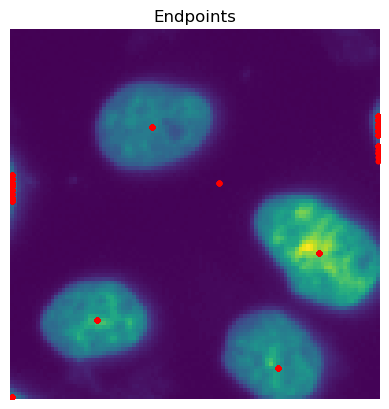

In [263]:
plt.imshow(image)
plt.plot(endpoints[1].ravel(),endpoints[0].ravel(),'r.')
plt.title('Endpoints')
plt.axis('off');

Spatially cluster the endpoints to create labels and assign the labels to the 
origin pixels

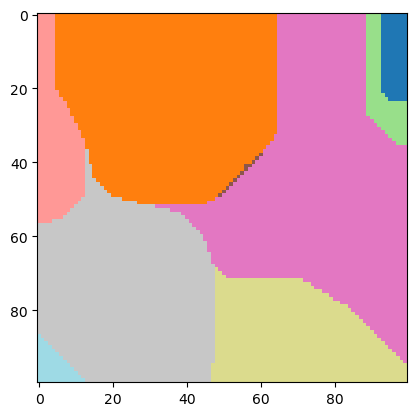

In [264]:
from skimage import measure

def cluster_endpoints(endpoints, min_area=0, max_distance=10):
    h = np.histogram2d(endpoints[0].ravel(), endpoints[1].ravel(), bins=np.array(image.shape), range=[[0,image.shape[0]],[0,image.shape[1]]])[0]
    hlabels = measure.label(h > min_area)
    labels = np.zeros(image.shape)
    for k in np.unique(hlabels):
        center = measure.centroid(hlabels==k)
        d = np.sqrt(sum(np.square(x-c) for x,c in zip(endpoints,center)))
        labels[d < max_distance] = k
    return labels

labels = cluster_endpoints(endpoints)
plt.imshow(labels,cmap='tab20')

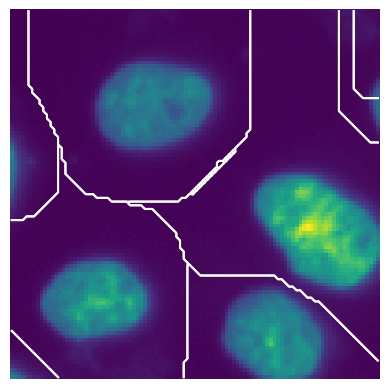

In [265]:
plt.imshow(image)
for k in np.unique(labels):
    contours = measure.find_contours(labels==k)
    for contour in contours:        
        plt.plot(contour[:,1],contour[:,0],'w')
plt.axis('off');


In short:

Text(0.5, 1.0, 'GVF')

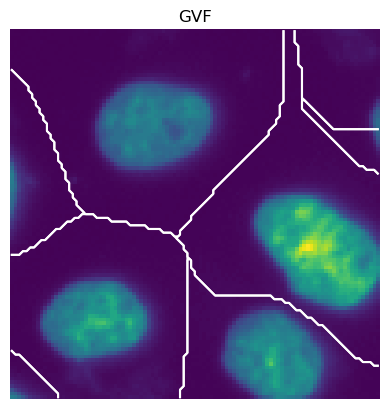

In [274]:
flow = gradient_vector_flow(image, 1, 1, 1, 100)
endpoints = backtrack_flow(flow)
labels = cluster_endpoints(endpoints)
plt.imshow(image)
for k in np.unique(labels):
    contours = measure.find_contours(labels==k)
    for contour in contours:        
        plt.plot(contour[:,1],contour[:,0],'w')
plt.axis('off')
plt.title('GVF')

We can apply the gradient vector flow to the signed distance to the mask

Text(0.5, 1.0, 'GVF on the signed distance transform')

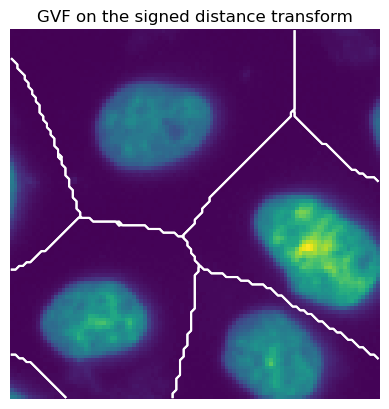

In [267]:
flt = ndimage.median_filter(image, 5)
mask =  flt > flt.mean()
distance = ndimage.distance_transform_edt(mask) - ndimage.distance_transform_edt(1-mask)
flow = gradient_vector_flow(distance, 0.5, 0.5, 1, 0)
endpoints = backtrack_flow(flow)
labels = cluster_endpoints(endpoints)

plt.imshow(image)
for k in np.unique(labels):
    contours = measure.find_contours(labels==k)
    for contour in contours:        
        plt.plot(contour[:,1],contour[:,0],'w')
plt.axis('off')
plt.title('GVF on the signed distance transform')


 Comparison with a watershed based approach

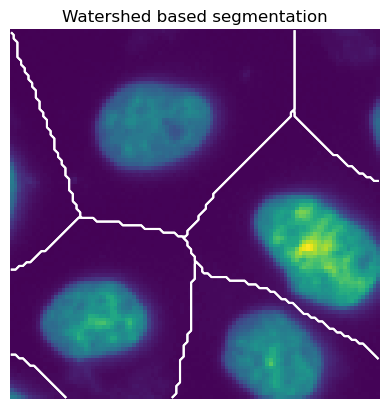

In [268]:
from skimage.segmentation import watershed
flt = ndimage.median_filter(image, 5)
mask =  flt > flt.mean()
distance = ndimage.distance_transform_edt(mask) - ndimage.distance_transform_edt(1-mask)
fltd = ndimage.gaussian_filter(distance, 2)
markers = ndimage.label(fltd == ndimage.grey_dilation(fltd, 3))[0]
labels = watershed(-fltd, markers)

plt.imshow(image)
for k in np.unique(labels):
    contours = measure.find_contours(labels==k)
    for contour in contours:        
        plt.plot(contour[:,1],contour[:,0],'w')
plt.axis('off')
plt.title('Watershed based segmentation');


## Vector field convolution

In (Li, B.; Acton, S.T. (2007). "Active contour external force using vector field convolution for image segmentation". IEEE Transactions on Image Processing. 16 (8): 2096–2106.), an convolution approach is proposed to estimate the vector flow.

The idea is to convolve the edge map by a vectorial kernel.

This can be used to compute a term such as:

$ \sum_{ij} ((p_i-p_j) - (v_i-v_j)) = \sum_{i} v_i - \sum_{j} ((p_i-p_j) v_j)$

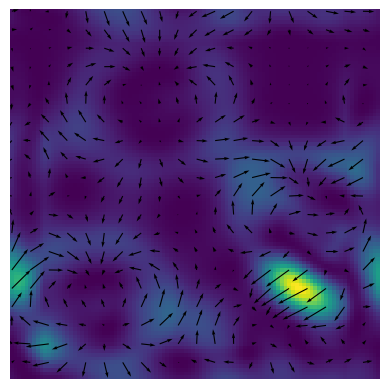

In [279]:
def vector_field_convolution(flow, radius):    
    fs0 = np.fft.fftfreq(flow.shape[1], 1 / flow.shape[1])
    fs1 = np.fft.fftfreq(flow.shape[2], 1 / flow.shape[2])
    grid = np.meshgrid(fs0, fs1, indexing='ij')    
    mag = np.sqrt(grid[1]**2 + grid[0]**2)
    mag[0,0] = 1
    kernel = (grid[0] + 1j * grid[1]) 
    kernel[mag > radius] = 0
    v = np.fft.ifft2(np.fft.fft2(kernel) * np.fft.fft2(flow[0] + 1j * flow[1]))    
    return np.stack([v.real, v.imag]) 

#flow = np.stack(np.gradient(image))
dflow = flow-vector_field_convolution(flow, 10)

# plt.subplot(131)
# plt.imshow(image)
# plt.subplot(132)
show_flow(dflow)
plt.imshow(np.square(dflow).sum(axis=0))


# endpoints = backtrack_flow(flow)
# labels = cluster_endpoints(endpoints)
# plt.imshow(image)
# for k in np.unique(labels):
#     contours = measure.find_contours(labels==k)
#     for contour in contours:        
#         plt.plot(contour[:,1],contour[:,0],'w')
# plt.axis('off')
# plt.title('GVF')


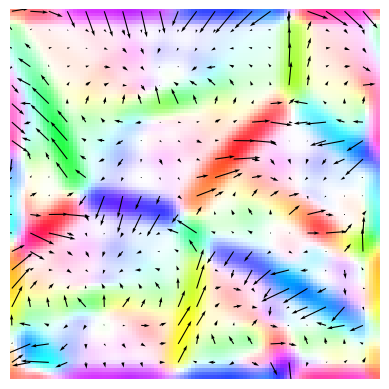

In [273]:
show_flow(dflow)

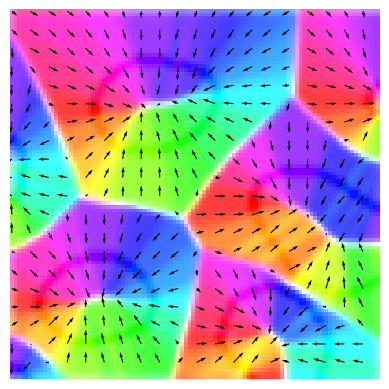

In [271]:
show_flow(flow)

In [272]:
grid = np.stack([g.ravel() for g in np.mgrid[:image.shape[0],:image.shape[1]]]).T
flow.reshape()

TypeError: reshape() takes exactly 1 argument (0 given)

We can now use the vector flow convolution as a cost function to minimize 

In [2]:
# Run this cell is your are developing the code locally
%load_ext autoreload
%autoreload 2
import sys
import site
site.addsitedir('../') 

In [94]:
from mug import denoising, utils
import torch
import torch.optim as optim 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

def VFCLoss(output,target):
    n = 7
    k = torch.linspace(-n//2+1, n//2, steps=n)
    weight = -torch.stack([torch.ones((1,n)) * k.reshape((n,1)),k * torch.ones((n,1))]).reshape((1,2,n,n))
    weight[0,0,n,n] = 1 - weight[0,0,n,n]
    weight[0,1,n,n] = 1 - weight[0,1,n,n]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return nn.functional.conv2d(output, weight.to(device)).square().sum()    

class VFCDataset(Dataset):
    """Pytorch dataset loading images """
    def __init__(self, image, N, length=10):
        super().__init__()
        self.image = torch.from_numpy(image).float().reshape((1,*image.shape))
        self.N = N
        self.number_of_images = length        

    def __len__(self):
        return self.number_of_images
    
    def __getitem__(self, idx):
        i = random.randint(0, self.image.shape[1]-self.N)
        j = random.randint(0, self.image.shape[2]-self.N)      
        img = self.image[:,i:i+self.N,j:j+self.N]
        return img, img

vfc_model = denoising.UNet2D(denoising.ResBlock2d, in_channels=1, out_channels=2, nfeatures=[16,32])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vfc_model.to(device)
image = io.imread('../data/nuclei.tif')
N = 100
train_ds = VFCDataset(image, N, 20)
valid_ds = VFCDataset(image, N, 20)
train_dl = DataLoader(train_ds, batch_size=12)
valid_dl = DataLoader(valid_ds, batch_size=12)

In [95]:
loss_fn = VFCLoss
optimizer = optim.AdamW(vfc_model.parameters(), lr = 3e-4)
num_epochs = 5000
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=num_epochs)
history = utils.train_network(vfc_model,optimizer,loss_fn,train_dl,valid_dl,num_epochs,device,scheduler)

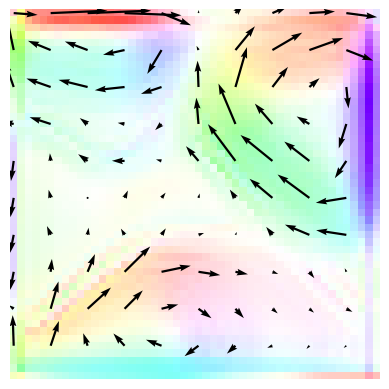

In [92]:
y = vfc_model(train_ds[0][0].reshape((1,1,N,N)).to(device))
show_flow(y.detach().cpu().numpy().squeeze())